<a href="https://colab.research.google.com/github/Bksimon/Emory_MSBA/blob/main/ROC_HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following code implements **Decision Tree Classifier**, **** and **Logisitic Regression Classifier** on cancer cells identication of either malignant or benign using 30 numerical features.

*   Hyper-paramter tuning done utilizing GridSearchCV
*   Transformed feature distributions with log, sqrt, and cbrt
*   Used K-fold cross validation and stratified k-fold validation (k=5)
*   Plotted learning curve for Logistic Regression
*   Plotted fitting curve for Decision Tree Depth
*   Compared AUC values from ROC curve for model selection/evaluation

In [1]:
# python 2/3 compatible codebase
from __future__ import division, print_function, unicode_literals

In [2]:
# import packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, learning_curve, ShuffleSplit, StratifiedShuffleSplit, validation_curve, StratifiedKFold, GridSearchCV, cross_val_score 
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from numpy import interp
sc = StandardScaler()

In [3]:
## Data Prep ##
# setup col names for dataset
col_names = ['id', 'diagnosis']
attribute_types = ['radius', 'texture', 'perimeter', 'area', 'smooth', 'compact', 'concavity', 'conc_points', 'symmetry', 'fractal_dim']
value_types = ['_mean', '_se', '_worst']

for i in range(len(value_types)):
  for j in range(len(attribute_types)):
    name = (attribute_types[j] + value_types[i])
    col_names.append(name)
col_names

['id',
 'diagnosis',
 'radius_mean',
 'texture_mean',
 'perimeter_mean',
 'area_mean',
 'smooth_mean',
 'compact_mean',
 'concavity_mean',
 'conc_points_mean',
 'symmetry_mean',
 'fractal_dim_mean',
 'radius_se',
 'texture_se',
 'perimeter_se',
 'area_se',
 'smooth_se',
 'compact_se',
 'concavity_se',
 'conc_points_se',
 'symmetry_se',
 'fractal_dim_se',
 'radius_worst',
 'texture_worst',
 'perimeter_worst',
 'area_worst',
 'smooth_worst',
 'compact_worst',
 'concavity_worst',
 'conc_points_worst',
 'symmetry_worst',
 'fractal_dim_worst']

In [4]:
# import data set
df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', header=None, names = col_names)

In [5]:
# set up display to show all columns
pd.set_option('display.max_columns', 35)

# Expore data
df.head()
df.dtypes

# Map diagnosis var to binary 0/1
df['diagnosis'] = df['diagnosis'].map({'M':1, 'B':0}).astype('int64')

# summary statistics
df.describe()
df.drop('id', axis=1)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smooth_mean,compact_mean,concavity_mean,conc_points_mean,symmetry_mean,fractal_dim_mean,radius_se,texture_se,perimeter_se,area_se,smooth_se,compact_se,concavity_se,conc_points_se,symmetry_se,fractal_dim_se,radius_worst,texture_worst,perimeter_worst,area_worst,smooth_worst,compact_worst,concavity_worst,conc_points_worst,symmetry_worst,fractal_dim_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,1,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,1.1760,1.2560,7.673,158.70,0.010300,0.02891,0.05198,0.02454,0.01114,0.004239,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,1,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,0.7655,2.4630,5.203,99.04,0.005769,0.02423,0.03950,0.01678,0.01898,0.002498,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,1,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,0.4564,1.0750,3.425,48.55,0.005903,0.03731,0.04730,0.01557,0.01318,0.003892,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,1,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,0.7260,1.5950,5.772,86.22,0.006522,0.06158,0.07117,0.01664,0.02324,0.006185,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


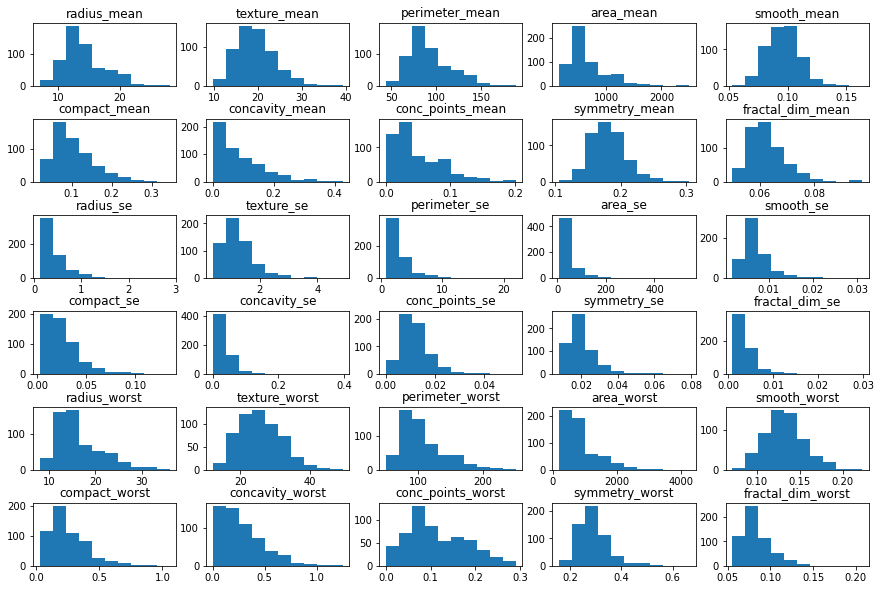

In [6]:
# examine varaible distributions for possible transformations
df.iloc[:,2:].hist(figsize=(12,8), grid=False)
plt.tight_layout(pad=.01)

# normal distributions: smooth_mean, smooth_worst, symmetry mean, and texture_worst

In [7]:
# transform variables to improve linear predictive fit for logistic regression
# normal distributions: smooth_mean, symmetry_mean, texture_worst, smooth_worst
sqrt = ["radius_mean", "texture_mean", "perimeter_mean",'concavity_mean','conc_points_mean',
        'concavity_se','conc_points_se','concavity_worst',"conc_points_worst"]

cbrt = ['compact_mean',"texture_se",'compact_se', 'compact_worst']

log = ["area_mean","fractal_dim_mean",'radius_se','perimeter_se','area_se',
       'smooth_se','symmetry_se','fractal_dim_se','radius_worst',
       'perimeter_worst','symmetry_worst','area_worst',
       'fractal_dim_worst']

# square root transformation
for i in sqrt:
  col_name = str(i) + '_sqrt'
  df[col_name] = np.sqrt(df[i])

# cube root transformation
for i in cbrt:
  col_name = str(i) + '_cbrt'
  df[col_name] = np.cbrt(df[i])

# log transformation
for i in log:
  col_name = str(i) + '_log'
  df[col_name] = np.log(df[i])

print(list(df.columns))

['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smooth_mean', 'compact_mean', 'concavity_mean', 'conc_points_mean', 'symmetry_mean', 'fractal_dim_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smooth_se', 'compact_se', 'concavity_se', 'conc_points_se', 'symmetry_se', 'fractal_dim_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smooth_worst', 'compact_worst', 'concavity_worst', 'conc_points_worst', 'symmetry_worst', 'fractal_dim_worst', 'radius_mean_sqrt', 'texture_mean_sqrt', 'perimeter_mean_sqrt', 'concavity_mean_sqrt', 'conc_points_mean_sqrt', 'concavity_se_sqrt', 'conc_points_se_sqrt', 'concavity_worst_sqrt', 'conc_points_worst_sqrt', 'compact_mean_cbrt', 'texture_se_cbrt', 'compact_se_cbrt', 'compact_worst_cbrt', 'area_mean_log', 'fractal_dim_mean_log', 'radius_se_log', 'perimeter_se_log', 'area_se_log', 'smooth_se_log', 'symmetry_se_log', 'fractal_dim_se_log', 'radius_worst_log', 'perimeter_worst_log', 'symm

In [8]:
# update to only include final columns
df = df.drop(sqrt, axis=1)
df = df.drop(cbrt, axis=1)
df = df.drop(log, axis=1)
#df = df.drop('id',axis=1)

# look at final columns
df.columns
df.shape

(569, 32)

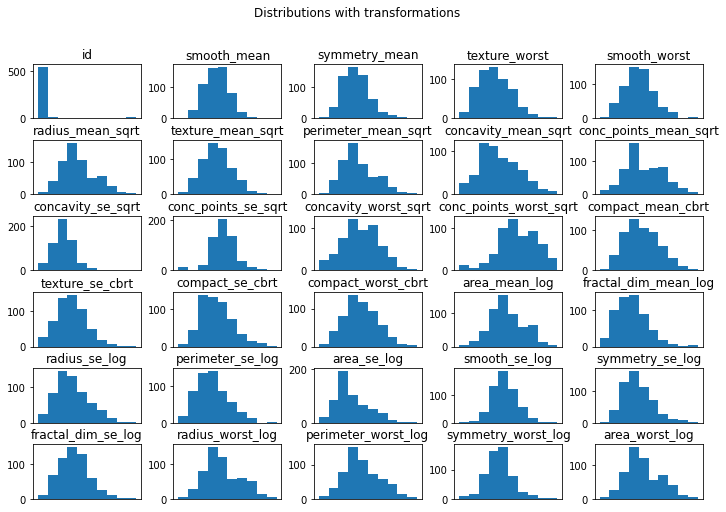

In [9]:
fig, axes = plt.subplots(6,5, figsize=(12,8))          # make subplot grid
fig.suptitle("Distributions with transformations")
plt.subplots_adjust(wspace=.3, hspace=.4)              # adjust spacing between plots
y_plot = df.iloc[:, df.columns != 'diagnosis'].columns # numeric cols only

#loop through columns and make subplots
for ax, y in zip(axes.flat, y_plot):
  ax.hist(df[y])
  ax.set_title(y)
  ax.xaxis.set_visible(False)
  

In [10]:
# look at balance of target var. Code Sourced from instructor provided notebook on K-nn
unique, counts = np.unique(df['diagnosis'], return_counts=True)


print("Frequency of each diagnosis is: ", dict(zip(unique, counts)), ".  As a reminder,\n0 represents a diagnosis of benign while 1 represents a diagnosis of malignant.")

Frequency of each diagnosis is:  {0: 357, 1: 212} .  As a reminder,
0 represents a diagnosis of benign while 1 represents a diagnosis of malignant.


In [11]:
# define features(x vars) and target (y)
df = df.dropna()

# features smooth_mean, . . . , fractal_dim_worst_log 
X = df.iloc[:, 2:]
# target variable = diagnosis
y = df.iloc[:,1]

In [12]:
### Model 1: Decision Tree ###
random_state = 42

# inner and outter 5 cross-validation splits
inner_cv = KFold(n_splits=5, shuffle=True, random_state=random_state)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=random_state)

gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                  param_grid=[{
                      'max_depth':[1,2,3,4,5,6,7,8,9,10,
                                   11,12,13,14,15,None],
                      'min_samples_leaf':[1,2,3,4,5,6]
                  }],
                  scoring='f1_macro',
                  cv=inner_cv
                  )

gs = gs.fit(X,y)
print(" Paranter Tuning #1")
print("Non-nested CV F1-score: ", gs.best_score_)
print("Optimal Parameter: ", gs.best_params_)
print("Optimal Estimator: ", gs.best_estimator_)
nested_score_gs = cross_val_score(gs, X=X, y=y, cv=outer_cv)
print("Nested CV F1-score: ", nested_score_gs.mean(), " +/- ", nested_score_gs.std())

 Paranter Tuning #1
Non-nested CV F1-score:  0.9528541465490804
Optimal Parameter:  {'max_depth': 6, 'min_samples_leaf': 6}
Optimal Estimator:  DecisionTreeClassifier(max_depth=6, min_samples_leaf=6, random_state=0)
Nested CV F1-score:  0.9414925740792588  +/-  0.0069157556424050744


In [13]:
# Standardize Data  
sc.fit(X)
X_std = sc.transform(X)

In [14]:
# Nested cross-validation for k-Nearest Neighbors

# inner cross validation layer for paramter optimization
gs_knn = GridSearchCV(estimator= KNeighborsClassifier(p=2, metric='minkowski'),
                      param_grid = {'n_neighbors': [1,3,5,7,9,11,13,15,17,19],
                                    'weights':['uniform', 'distance']},
                      scoring='f1_macro',
                      cv=5,
                      n_jobs=8
                      )
gs_knn = gs_knn.fit(X_std, y)

print("Non-nested CV F1-score: ", gs_knn.best_score_)
print("Optimal Paramter: ", gs_knn.best_params_)
print("optimal Estimator: ", gs_knn.best_estimator_)

# outer cross validation layer for performance estimate
outercv_fscore = cross_val_score(gs_knn, X_std, y, scoring = 'f1_macro', cv=5)
print("nested CV F1-score: ", outercv_fscore.mean(), "+/-", outercv_fscore.std())

Non-nested CV F1-score:  0.9696744603165481
Optimal Paramter:  {'n_neighbors': 3, 'weights': 'uniform'}
optimal Estimator:  KNeighborsClassifier(n_neighbors=3)
nested CV F1-score:  0.9678029629688603 +/- 0.02291867312556819


In [15]:
### Model 2: K-Nearest-Neighbors (K-nn) ###

# Normalize Data with pipeline
pipe = Pipeline([
                 ('sc', StandardScaler()),
                 ('knn', KNeighborsClassifier(p=2, metric='minkowski'))
])

# Parameters to optimize
params = {
    'knn__n_neighbors': [1,3,5,7,9,11,13,15,17,19,21],
    'knn__weights': ['uniform', 'distance']
}

# choosing k for Knn
gs_knn = GridSearchCV(estimator=pipe,
                      param_grid = params,
                      scoring = 'accuracy',
                      cv = inner_cv)

#print(len(y))
gs_knn = gs_knn.fit(X,y)
print("\nParamter Tuning #6")
print("Non-nested CV Accuracy: ", gs_knn.best_score_)
print("Optimal Parameter: ", gs_knn.best_params_)
print("Optimal Estimator: ", gs_knn.best_estimator_)
nested_score_gs_knn = cross_val_score(gs_knn, X=X, y=y, cv=outer_cv)
print("Nested CV Accuracy: ", nested_score_gs_knn.mean(), " +/- ", nested_score_gs_knn.std())


Paramter Tuning #6
Non-nested CV Accuracy:  0.9648191274646795
Optimal Parameter:  {'knn__n_neighbors': 3, 'knn__weights': 'uniform'}
Optimal Estimator:  Pipeline(steps=[('sc', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=3))])
Nested CV Accuracy:  0.9560316721006055  +/-  0.022958624829730188


In [16]:
from scipy.sparse.construct import rand
### Model 3: Logistic Regression ###

# Hyper-paramter tuning for Logistic Regression
gs_lr = GridSearchCV(estimator=LogisticRegression(random_state=random_state, solver='liblinear'),
                     param_grid={'C': [.00001, .0001, .001, .01, .1, 10, 100, 1000,
                                       10000, 100000, 1000000],
                                 'penalty': ['l1','l2']},
                     scoring='f1_macro',
                     cv=inner_cv,
                     n_jobs=8
                     )
gs_lr = gs_lr.fit(X,y)
print("Non-nested CV F1-score: ", gs_lr.best_score_)
print("Optimal Paramter: ", gs_lr.best_params_)
print("Optimal Estimator: ", gs_lr.best_estimator_)
nested_score_gs_lr = cross_val_score(gs_lr, X=X, y=y, cv=outer_cv)
print("Nested CV F1-score:", nested_score_gs_lr.mean(), " +/- ", nested_score_gs_lr.std())

Non-nested CV F1-score:  0.9718386170801889
Optimal Paramter:  {'C': 100, 'penalty': 'l2'}
Optimal Estimator:  LogisticRegression(C=100, random_state=42, solver='liblinear')
Nested CV F1-score: 0.9680651131428153  +/-  0.01707576144103173


In [17]:
### Model Evaluation ###
 # code for function that plots learning curve
 # takes estimator e.g. logistic regression as input, plot title, X features and y target for precision
 # y limits for y-axis(optional), specification for cross-validation folds (optional),
 # The number or processing jobs to run in parallel (optional), and
 # The scoring used to evaluate performance(optional, defaults to estimator default)

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                         n_jobs=1, train_sizes=np.linspace(.1,1,5),
                         scorer=None, ylab="Score"):
   # configure plot
   plt.figure()                   #set matplotlib figure
   plt.title(title)               #set plot title
   if ylim is not None:           #add y-lims
     plt.ylim(*ylim)      
   plt.xlabel("Training Examples")#add xlabels
   plt.ylabel(ylab)               #add ylabels
   plt.grid(color='#E5E5E5')      #show light gridlines

   # get cross-validated training and test score performance for dif training set sizes
   train_sizes, train_scores, test_scores = learning_curve(
       estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scorer
   )
   # get avg values and std associated with training and test score
   train_scores_mean = np.mean(train_scores, axis=1)
   train_scores_std = np.std(train_scores, axis=1)
   test_scores_mean = np.mean(test_scores, axis=1)
   test_scores_std = np.std(test_scores, axis=1)

   # show filled confidence band around training and test scores
   # blue and orange shades used for color-blind friendlt palette
   plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=.05, 
                    color="#de6011")
   plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=.10, 
                    color="#1171de")
   
   # plot training and test scores
   plt.plot(train_sizes, train_scores_mean, 'o-', color="#de6011",
            label="Avg Training Score")
   plt.plot(train_sizes, test_scores_mean, 'o-', color="#1171de",
            label="Avg Test Score")
   
   # plot legend at best location
   plt.legend(loc="best")
   return plt

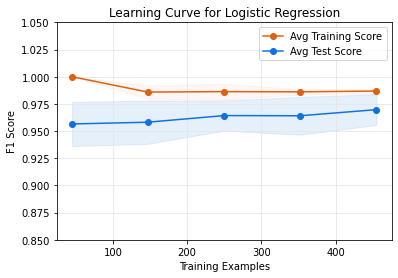

In [18]:
title = "Learning Curve for Logistic Regression"
cv=StratifiedShuffleSplit(n_splits=5, test_size=.2, random_state=random_state) 
# specifiy stratified cv indexes, use estimator paramter values from before
estimator = LogisticRegression(C=100, random_state=random_state, penalty='l2', solver='liblinear')
plot_learning_curve(estimator, title, X,y, {.85,1.05}, cv=cv, n_jobs=4, scorer='f1_macro', ylab="F1 Score")

plt.show()

In [20]:
### Fitting Curve ###

# specify possible paramter values for different tree depths
# chosen numbers 1-30
param_range = list(range(1,31,1))

# Determine training and test scores for varying parameter values using validation curve
# The splitting criterion is set to entropy, but no other paramter constraints are set e.g. min_sample_leaf
# This is to ensure the graph shows the tradeoff between complexity and performance for max_depth only
train_scores, test_scores, = validation_curve(
    estimator = DecisionTreeClassifier(random_state=random_state, criterion='gini'),
    X=X, y=y, 
    param_name="max_depth", param_range=param_range,
    cv=5,
    scoring='f1_macro',
    n_jobs=8  
)

In [24]:
# get training and test score mean +/- std
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

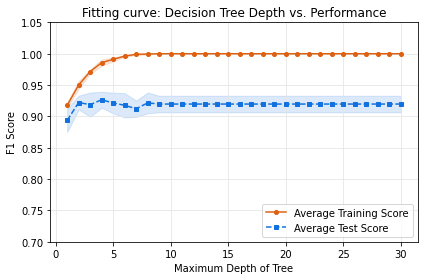

In [26]:
# setup figure
plt.figure()

# plot train accuracy means of cross-validation for all paramter values of max depth
plt.plot(param_range, train_mean, 
         color='#de6011', marker='o',
         markersize=4, label='Average Training Score')

# Fill the area around the line to indicate the size of std deviations of performance
# for the training data.
plt.fill_between(param_range, train_mean + train_std, 
                 train_mean - train_std, alpha=.15,
                 color='#de6011')

# Plot test accuracy means of cross validation for all paramters C in param_range
plt.plot(param_range, test_mean, 
         color='#1171de', linestyle='--',
         marker='s', markersize=4,
         label='Average Test Score')

# Fill the area around the line to indicate size of the std deviations of 
# performance for test data.
plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=.15,color='#1171de')

# Grid Axes Titles
plt.grid(color='#E5E5E5')
#plt.xscale('Maximum Depth of Tree')
plt.legend(loc='lower right')
plt.title('Fitting curve: Decision Tree Depth vs. Performance')
plt.xlabel('Maximum Depth of Tree')
plt.ylabel('F1 Score')
plt.ylim([.7, 1.05])
plt.tight_layout()
plt.show()

In [27]:
from sklearn import neighbors
### ROC Curve ###
# AUC values for Decision Tree, Knn, and Logistic Regression

# Used paramter values based on optimization results from nested cross validation.
# However, this is being implemented in the same dat set, which will likely inflate
# the performance estimates across all the classifiers.  For compartive purposes,
# this may still show us which classifier performs relatively better.

# Model 1: Decision Tree Classifier
clf1 = DecisionTreeClassifier(max_depth=6, min_samples_leaf=6, random_state=42)

# Model 2: K-nn Classifier
clf2 = neighbors.KNeighborsClassifier(n_neighbors=3, weights='uniform', p=2, metric='minkowski')

# Model 3: Logistic Regression Classifier
clf3 = LogisticRegression(penalty='l2', C=100, random_state=42)

# Label the classifiers and group for looping
clf_labels = ['Decision tree', 'Knn', 'Logistic Regression']
all_clf = [clf1, clf2, clf3]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


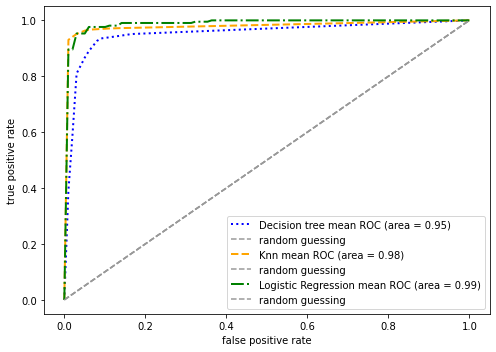

<Figure size 3600x3600 with 0 Axes>

In [28]:
# Create for loop to build TOC cruve based on avg tpr/fpr rates from
# 5-fold cross validation

# create stratified k-fold samples to loop over
# use standardized data for it to be Knn friendly
cv = list(StratifiedKFold(n_splits=10, shuffle=True, random_state=42).split(X_std,y))

# setup figure size
fig = plt.figure(figsize=(7,5))

# Set up additional variables for plot loop
colors = ['blue', 'orange', 'green']
linestyles = [':', '--', '-.', '-']

# Create array with false positive rate values
mean_fpr = np.linspace(0,1,100)

for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
  mean_tpr = 0.0
  for i, (train,test) in enumerate(cv):
    # for each classifier in a fold, get class probabilty estimates
    probas = clf.fit(X_std[train], y[train]).predict_proba(X_std[test])
    fpr, tpr, tresholds = roc_curve(y[test], probas[:,1], pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
  mean_tpr /= len(cv)
  mean_tpr[-1] = 1.0
  mean_auc = auc(mean_fpr, mean_tpr)

  plt.plot(mean_fpr, mean_tpr, 'k--', color=clr, linestyle=ls,
           label=label+' mean ROC (area = %0.2f)' % mean_auc, lw=2)
  
  # Add plot line for random guessing classifier
  plt.plot([0,1], [0,1], linestyle='--', color=(.6, .6, .6), label='random guessing')

  # Figure paramters: x-axis limits, y lims, labels of axes, legend pos
plt.xlim([-.05, 1.05])
plt.ylim([-.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend(loc='lower right')

#show compact figure
plt.tight_layout()
plt.figure(figsize=(50,50))
plt.show()